In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\langl\AppData\Local\Temp\ipykernel_21880\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [25]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [26]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [27]:
# session link
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


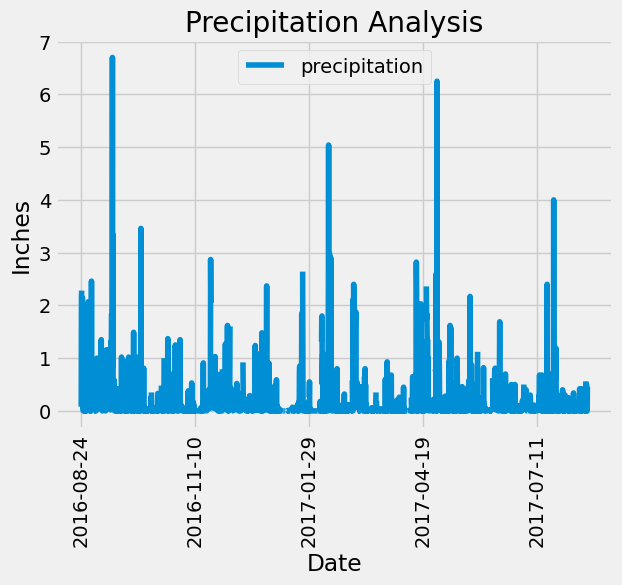

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calc date one year from the last date in data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# query to retrieve data and precipitation
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# save query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Analysis')
plt.show()

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [31]:
# Design query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print({total_stations})

{9}


In [32]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

# query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), 
 func.max(Measurement.tobs), 
 func.avg(Measurement.tobs))\
 .filter(Measurement.station == most_active_station_id)\
 .all()

# unpack result
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print({lowest_temp})
print({highest_temp})
print({avg_temp})

{54.0}
{85.0}
{71.66378066378067}


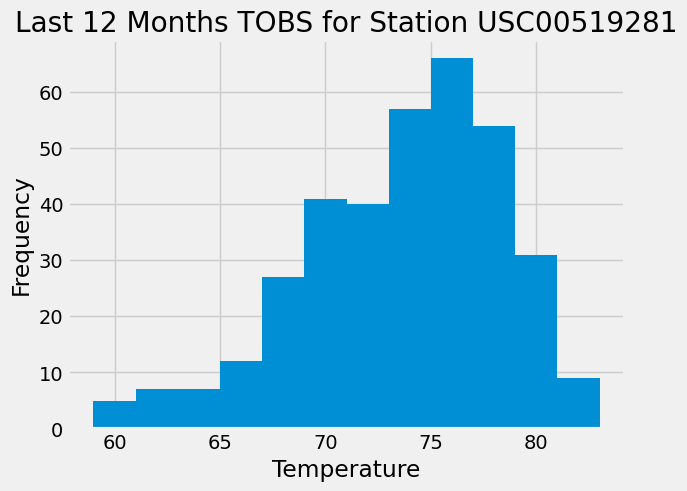

In [34]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'

# last date of observation for the most active station
last_date = session.query(Measurement.date)\
    .filter(Measurement.station == most_active_station_id)\
    .order_by(Measurement.date.desc())\
    .first()[0]

last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Query last 12 months of TOBS data for most active station
tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago)\
    .all()

# Extract temperature observations from query results
temperatures = [temp[0] for temp in tobs_data]

# Plot the results as histogram
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Last 12 Months TOBS for Station ' + most_active_station_id)
plt.show()


# Close Session

In [19]:
# Close Session
session.close()